In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif"

from transformers import AutoProcessor, Qwen2VLForConditionalGeneration
from qwen_vl_utils import process_vision_info

In [2]:
model_path = "/work/piyush/pretrained_checkpoints/LamRA-Ret/"
# model_path = "/work/piyush/pretrained_checkpoints/LamRA/LamRA-Ret-Pretrained-merged"
# model_path = '/work/piyush/pretrained_checkpoints/LamRA/LamRA-Ret-Pretrained-on-Ego4D-merged'
# model_path = '/work/piyush/pretrained_checkpoints/LamRA/LamRA-Ret-Pretrained-on-Ego4D+NLI-merged/'
model = Qwen2VLForConditionalGeneration.from_pretrained(
    model_path, torch_dtype=torch.bfloat16, low_cpu_mem_usage=True, device_map='auto',
)
processor = AutoProcessor.from_pretrained(model_path)
tokenizer = processor.tokenizer 

`Qwen2VLRotaryEmbedding` can now be fully parameterized by passing the model config through the `config` argument. All other arguments will be removed in v4.46


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [3]:
def add_embed_token(tokenizer, model, emb_token="<emb>"):
    emb_tokens = [emb_token]
    num_new_tokens = tokenizer.add_tokens(emb_tokens)
    assert len(emb_tokens) == num_new_tokens

    model.resize_token_embeddings(len(tokenizer))

    emb_token_ids = tokenizer.convert_tokens_to_ids(emb_tokens)
    model.config.emb_token_ids = emb_token_ids


def get_embed_feature(hidden_states, input_ids, embed_index):
    embed_indices = torch.argmax((input_ids == embed_index).int(), dim=1)
    embed_features = hidden_states[torch.arange(len(embed_indices)), embed_indices - 1]
    return embed_features


def qwen2vl_process(messages, processor):
    texts = [
      processor.apply_chat_template(
          msg, tokenize=False, add_generation_prompt=True,
      )
      for msg in messages
    ]
    image_inputs, video_inputs = process_vision_info(messages)
    inputs = processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    # inputs = inputs.to("cuda")
    return inputs

In [4]:
add_embed_token(tokenizer, model)

**Test on a image**

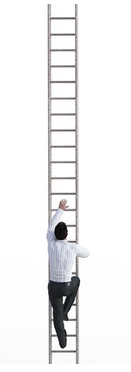

In [5]:
import PIL, PIL.Image

image_path = '../../TimeBound.v1/sample_data/man_at_ladder_bottom.png'
PIL.Image.open(image_path)

In [6]:
def prepare_inputs_image_text_to_text(query: dict, candidates: list):
    query_message = [
      {
          "role": "user",
          "content": [
              {"type": "image", "image": query['image_path']},
              {"type": "text", "text": query['text']},
              {"type": "text", "text": f"\nSummarize above image and sentence in one word: "}
          ],
      },
      {
          "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
      },
    ]
    candidate_messages = [
        [
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": f"{c}\nSummarize above sentence in one word: "},
              ],
          },
          {
              "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
          },
        ] for c in candidates
    ]
    
    
    query_inputs = qwen2vl_process([query_message], processor)
    candidates_inputs = qwen2vl_process(candidate_messages, processor)
    return query_inputs, candidates_inputs

In [7]:
query = {
    'image_path': image_path,
    'text': "Find an image caption describing the following everyday image.",
}
candidates = [
    'a man climbing up a ladder',
    'a woman climbing up a ladder',
    'a person climbing down a ladder',
]

# query_message = [
#   {
#       "role": "user",
#       "content": [
#           {"type": "image", "image": query['image_path']},
#           {"type": "text", "text": query['text']},
#           {"type": "text", "text": f"\nSummarize above image and sentence in one word: "}
#       ],
#   },
#   {
#       "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
#   },
# ]
# candidate_messages = [
#     [
#       {
#           "role": "user",
#           "content": [
#               {"type": "text", "text": f"{c}\nSummarize above sentence in one word: "},
#           ],
#       },
#       {
#           "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
#       },
#     ] for c in candidates
# ]


# query_inputs = qwen2vl_process([query_message], processor)
# candidates_inputs = qwen2vl_process(candidate_messages, processor)

query_inputs, candidates_inputs = prepare_inputs_image_text_to_text(query, candidates)

In [8]:
with torch.no_grad():

    # Compute embeddings for the candidates
    candidates_hidden_state = model(
        **candidates_inputs, output_hidden_states=True, return_dict=True,
    ).hidden_states[-1]
    candidates_embeds = get_embed_feature(
        candidates_hidden_state, candidates_inputs['input_ids'], model.config.emb_token_ids[0],
    )

    # Compute embeddings for query
    query_hidden_state = model(
        **query_inputs, output_hidden_states=True, return_dict=True,
    ).hidden_states[-1]
    query_embeds = get_embed_feature(
        query_hidden_state, query_inputs['input_ids'], model.config.emb_token_ids[0],
    )

    candidates_embeds = F.normalize(candidates_embeds, dim=-1)
    query_embeds = F.normalize(query_embeds, dim=-1)

print(query_embeds @ candidates_embeds.t())

tensor([[0.7852, 0.6562, 0.7031]], dtype=torch.bfloat16)


**Test on a video query**

In [9]:
def prepare_inputs_video_text_to_text(query: dict, candidates: list):
    query_message = [
      {
          "role": "user",
          "content": [
              {"type": "video", "video": query['video_path']},
              {"type": "text", "text": query['text']},
              {"type": "text", "text": f"\nSummarize above image and sentence in one word: "}
          ],
      },
      {
          "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
      },
    ]
    candidate_messages = [
        [
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": f"{c}\nSummarize above sentence in one word: "},
              ],
          },
          {
              "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
          },
        ] for c in candidates
    ]
    
    
    query_inputs = qwen2vl_process([query_message], processor)
    candidates_inputs = qwen2vl_process(candidate_messages, processor)
    return query_inputs, candidates_inputs


query = {
    'video_path': '../../TimeBound.v1/sample_data/folding_paper.mp4',
    'text': "Find a video caption describing the following everyday video."
}
candidates = [
    'a person folding a piece of paper',
    'a person tearing apart a paper',
    'a person unfolding a piece of paper',
]
query_inputs, candidates_inputs = prepare_inputs_video_text_to_text(query, candidates)

qwen-vl-utils using decord to read video.


In [10]:
def prepare_inputs_vt2t_query(query):
    query_message = [
        {
          "role": "user",
          "content": [
              {"type": "video", "video": query['video_path'], 'max_frames': 8},
              {"type": "text", "text": query['text']},
              {"type": "text", "text": f"\nSummarize above image and sentence in one word: "}
          ],
        },
        {
          "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
        },
    ]
    query_inputs = qwen2vl_process([query_message], processor)
    return query_inputs


def prepare_inputs_text_candidates(candidates):
    candidate_messages = [
        [
          {
              "role": "user",
              "content": [
                  {"type": "text", "text": f"{c}\nSummarize above sentence in one word: "},
              ],
          },
          {
              "role": "assistant", "content": [{"type": "text", "text": f"<emb>."}]
          },
        ] for c in candidates
    ]
    candidates_inputs = qwen2vl_process(candidate_messages, processor)
    return candidates_inputs

In [11]:
query_inputs['pixel_values_videos'].shape, query_inputs['video_grid_thw']

(torch.Size([2160, 1176]), tensor([[ 4, 18, 30]]))

In [12]:
with torch.no_grad():

    # Compute embeddings for the candidates
    candidates_hidden_state = model(
        **candidates_inputs, output_hidden_states=True, return_dict=True,
    ).hidden_states[-1]
    candidates_embeds = get_embed_feature(
        candidates_hidden_state, candidates_inputs['input_ids'], model.config.emb_token_ids[0],
    )
    candidates_embeds = F.normalize(candidates_embeds, dim=-1)

    # Compute embeddings for query
    query_hidden_state = model(
        **query_inputs, output_hidden_states=True, return_dict=True,
    ).hidden_states[-1]
    query_embeds = get_embed_feature(
        query_hidden_state, query_inputs['input_ids'], model.config.emb_token_ids[0],
    )
    query_embeds = F.normalize(query_embeds, dim=-1)

print(query_embeds @ candidates_embeds.t())

tensor([[0.6484, 0.6484, 0.6953]], dtype=torch.bfloat16)


#### Run large-scale evaluation on CiA

In [13]:
import shared.utils as su

In [20]:
from notebooks.eval_care_retrieval import load_data, compute_metrics, print_metrics_as_latex_row

df = load_data(dataset='charades')
df = df.drop_duplicates(subset=['id'])
df.shape

Number of rows:  5498
Sample row: 
{
    "id_base": "YSKX3",
    "subject": "CP6Y",
    "scene": "Bedroom",
    "quality": 5.0,
    "relevance": 6.0,
    "verified": "Yes",
    "length": 16.62,
    "cls_id": "c077",
    "template": "putting a pillow somewhere",
    "start_time": 12.1,
    "end_time": 16.62,
    "object_id": "o027",
    "noun": "na",
    "verb_id": "v016",
    "verb": "put",
    "label": "putting a pillow somewhere",
    "id": "YSKX3_12.1_16.6",
    "chiral_label": 0.0,
    "chiral_triplet_id": "a9be73ec",
    "text_id": "a9be73ec_0.0",
    "video_path": "/scratch/shared/beegfs/piyush/datasets/Charades/Charades_v1_480_cut_clips/YSKX3_12.1_16.6.mp4"
}


(5498, 21)

In [21]:
# Compute video embeddings
video_ids = df.id.unique()
video_feat = {}
j = 0
for video_id in su.log.tqdm_iterator(video_ids, desc='Computing video features'):
    video_path = df[df.id == video_id].video_path.unique()[0]
    query_inputs = prepare_inputs_vt2t_query(
        {
            'video_path': video_path,
            'text': "Find a video caption describing the following everyday video.",
        }
    )
    with torch.no_grad():
    
        # Compute embeddings for query
        query_hidden_state = model(
            **query_inputs, output_hidden_states=True, return_dict=True,
        ).hidden_states[-1]
        query_embeds = get_embed_feature(
            query_hidden_state, query_inputs['input_ids'], model.config.emb_token_ids[0],
        )
        query_embeds = F.normalize(query_embeds, dim=-1).cpu()

    video_feat[video_id] = query_embeds
    j += 1

Computing video features:   0%|          | 0/5498 [00:00<?, ?it/s]

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


In [22]:
# Embed candidates (text captions)
text_ids = df['text_id'].unique()
texts_feat = {}
for text_id in su.log.tqdm_iterator(text_ids, desc='Computing text features'):
    text = df[df.text_id == text_id].template.unique()[0]

    candidates_inputs = prepare_inputs_text_candidates([text])
    with torch.no_grad():
        candidates_hidden_state = model(
            **candidates_inputs, output_hidden_states=True, return_dict=True,
        ).hidden_states[-1]
        candidates_embeds = get_embed_feature(
            candidates_hidden_state, candidates_inputs['input_ids'], model.config.emb_token_ids[0],
        )
        candidates_embeds = F.normalize(candidates_embeds, dim=-1)

    # zt = tfc(text)
    # zt = torch.nn.functional.normalize(zt, dim=-1)
    texts_feat[text_id] = candidates_embeds[0]

Computing text features:   0%|          | 0/56 [00:00<?, ?it/s]

In [23]:
# Sanity check
video_feat[video_id].shape, texts_feat[text_id].shape

(torch.Size([1, 3584]), torch.Size([3584]))

In [24]:
video_feat_ = {k: v.float().squeeze(0) for k, v in video_feat.items()}
texts_feat_ = {k: v.float() for k, v in texts_feat.items()}

In [25]:
metrics = compute_metrics(df, video_feat_, texts_feat_, show_metrics=True)
print_metrics_as_latex_row(metrics)

{
    "txt_r1": 52.14623499454347,
    "txt_r5": 100.0,
    "txt_r10": 100.0,
    "txt_r_mean": 84.04874499818115,
    "img_r1": 60.485631138595856,
    "img_r5": 98.33575845762095,
    "img_r10": 100.0,
    "img_r_mean": 86.27379653207227,
    "r_mean": 85.16127076512672,
    "txt_map": 76.07311749727174,
    "img_map": 52.96578555196058,
    "map_mean": 64.51945152461616
}
{
    "txt_r1": 20.334667151691526,
    "txt_r5": 56.98435794834485,
    "txt_r10": 75.91851582393599,
    "txt_r_mean": 51.07918030799078,
    "img_r1": 42.857142857142854,
    "img_r5": 80.29023541027905,
    "img_r10": 92.85714285714286,
    "img_r_mean": 72.00150704152159,
    "r_mean": 61.54034367475619,
    "txt_map": 37.432392724501035,
    "img_map": 17.13519463194735,
    "map_mean": 27.28379367822419,
    "chiral_label": 0.5187340851218625
}
{
    "txt_r1": 11.349581666060386,
    "txt_r5": 39.596216806111315,
    "txt_r10": 57.31174972717352,
    "txt_r_mean": 36.08584939978174,
    "img_r1": 26.78571428

In [ ]:
52.1 & 11.3 & 53.0 & 9.1

Number of unique labels: 22


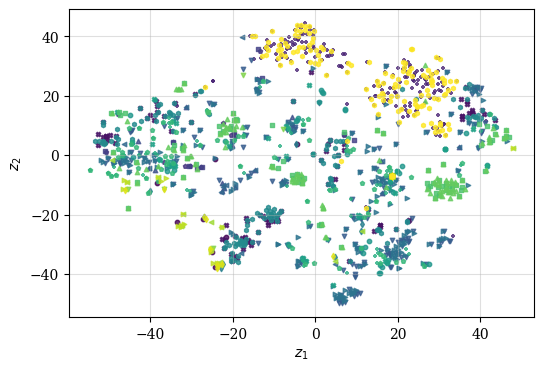

In [38]:
video_embeddings = torch.stack([video_feat_[k] for k in video_feat_])
labels = [df[df.id == k].template for k in video_feat_]
triplet_ids = [df[df.id == k].chiral_triplet_id for k in video_feat_]
su.visualize.show_projections_with_labels(
    video_embeddings, labels, legend=False
)

Number of unique labels: 2


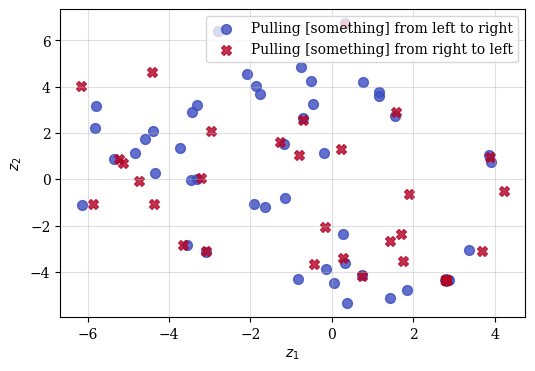

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


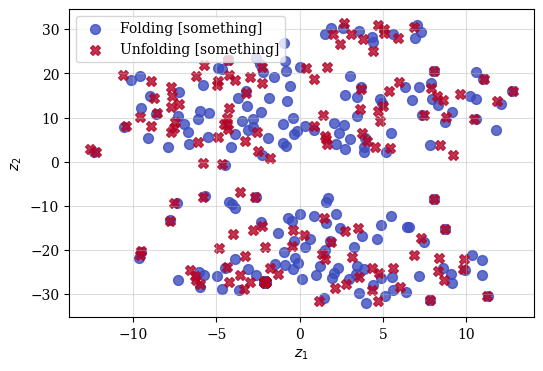

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


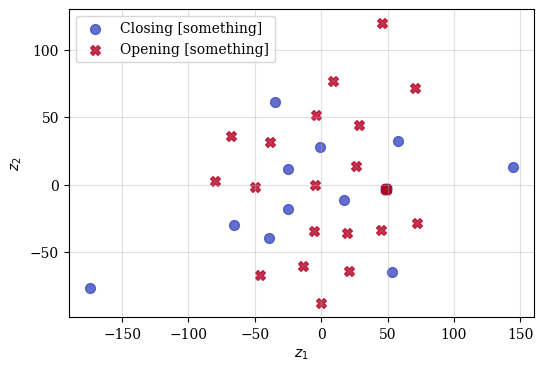

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


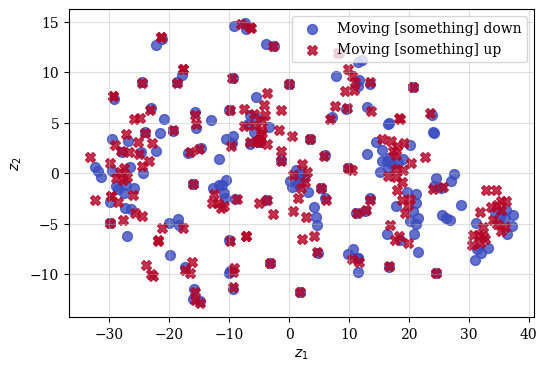

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


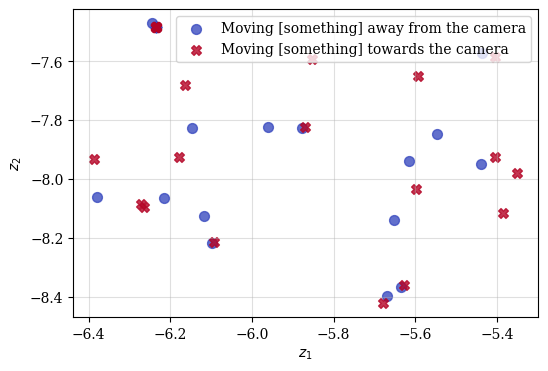

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


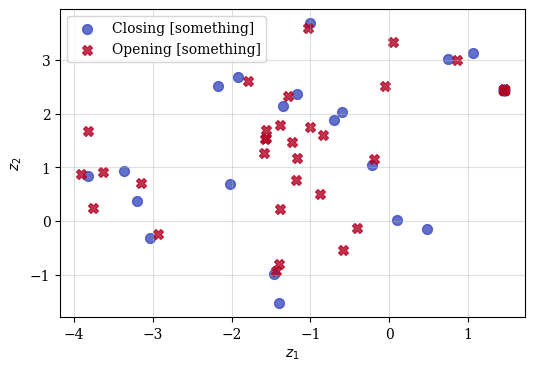

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


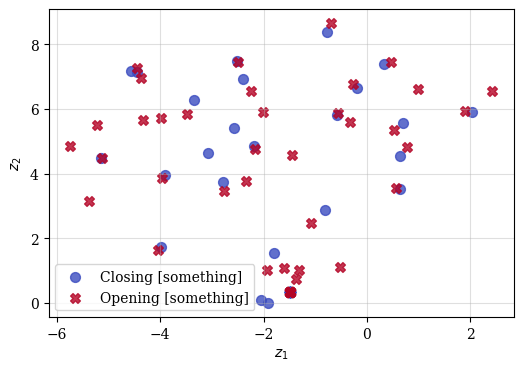

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


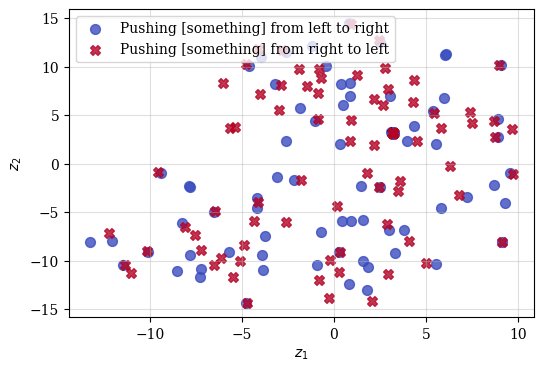

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


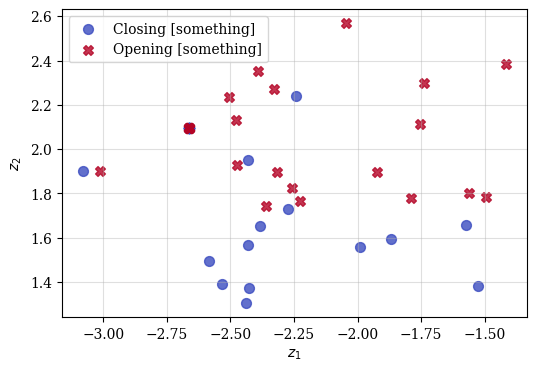

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


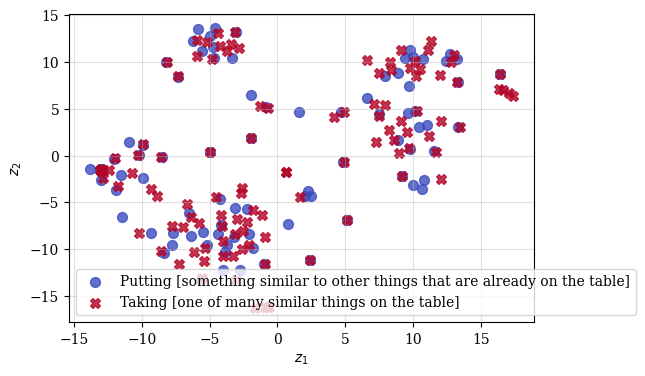

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


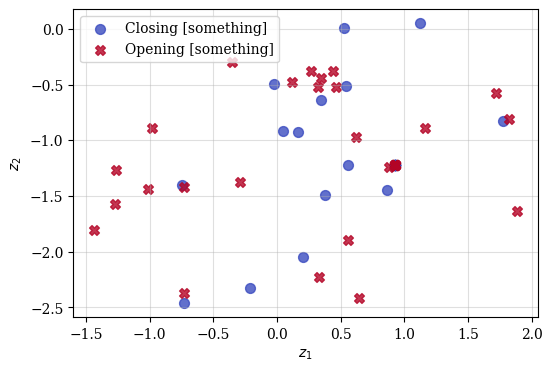

----------------------------------------------------------------------------------------------------
Number of unique labels: 2


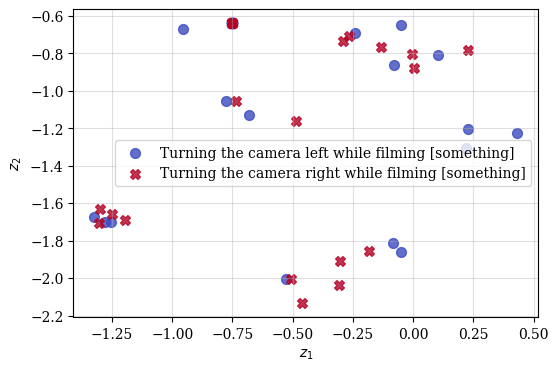

----------------------------------------------------------------------------------------------------


In [41]:
unique_triplet_ids = np.unique(triplet_ids)
for t in unique_triplet_ids:
    index = np.where(np.array(triplet_ids) == t)[0]
    if len(index) < 25:
        continue
    su.visualize.show_projections_with_labels(
        video_embeddings[index], np.array(labels)[index], legend=True, legend_ncol=1, cmap='coolwarm', method='tsne', show=True, s=50,
    )
    print('-' * 100)
    